In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import random

# Question 1
## Selecting the points

In [37]:
### Don't run unless you want new points. I have saved the points I used as a npy file.

%matplotlib tk
image_points = []
fig = plt.figure(figsize=(20,30))
img=mpimg.imread('../calibration-data/calib-object.jpg')

def onclick(event):
    ix, iy = event.xdata, event.ydata
    # print(ix, iy)
    image_points.append([ix, iy])

cid = fig.canvas.mpl_connect('button_press_event', onclick)

imgplot = plt.imshow(img)
plt.show()

## Plotting the selected points

In [350]:
## Loading the points I have saved earlier
image_points = np.load("image_points.npy")

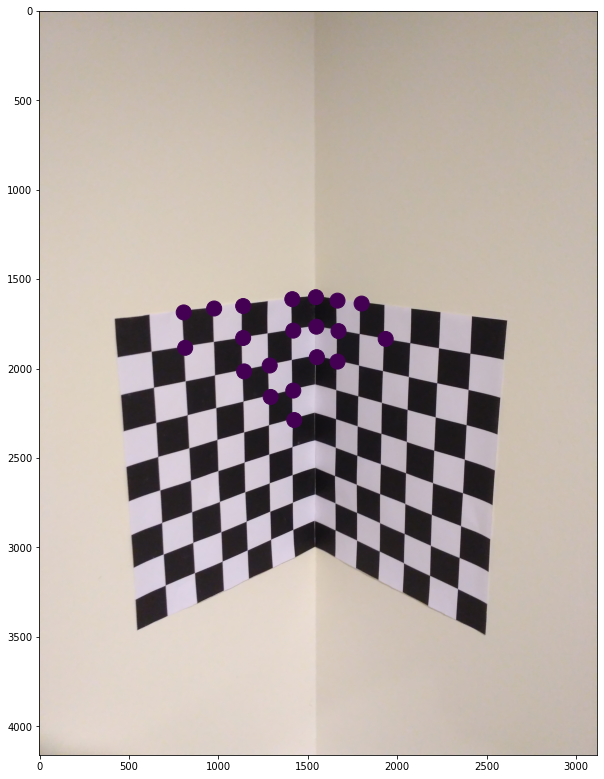

In [351]:
%matplotlib inline
N = image_points.shape[0]
image_points = np.array(image_points)
fig = plt.figure(figsize=(10,15))

img=mpimg.imread('../calibration-data/calib-object.jpg')
imgplot = plt.imshow(img)

# colors = np.random.rand(N)
colors = np.ones((N,1))
area = (15 * np.ones(N))**2 

plt.scatter(image_points[:,0], image_points[:,1], c=colors, s=area)
plt.show()

In [352]:
def hom_coords(x,X):

    n = x.shape[0]
    size = (n,1)
    ones = np.ones(size)
    x = np.concatenate(
        (x,ones),
        axis = 1)
    X = np.concatenate(
        (X,ones),
        axis = 1)
    return x, X


x = image_points
# X represents the 3D world points
X = []
X.append([0,0,28])
X.append([28,0,0])
X.append([0,28,28])
X.append([28,28,0])
X.append([0,56,0])
X.append([28,56,0])
X.append([0,0,0])
X.append([0,28,0])
X.append([56,0,0])
X.append([84,28,0])
X.append([0,0,84])
X.append([0,28,84])
X.append([0,56,84])
X.append([0,56,56])
X.append([0,84,56])
X.append([0,84,28])
X.append([0,112,28])
X.append([0,0,112])
X.append([0,0,140])
X.append([0,28,140])
X = np.array(X)

x_hom,X_hom = hom_coords(x,X)

In [353]:
#DLT function takes as input 
#the image points and world points
#return a 3x4 matrix
def DLT(x,X):
    P = np.random.randn(3,4)
    A = []
    for i in range(x.shape[0]):
        A.append([X[i,0],X[i,1],X[i,2],1,0,0,0,0,-X[i,0]*x[i,0],-X[i,1]*x[i,0],-X[i,2]*x[i,0],-x[i,0]])
        A.append([0,0,0,0,X[i,0],X[i,1],X[i,2],1,-X[i,0]*x[i,1],-X[i,1]*x[i,1],-X[i,2]*x[i,1],-x[i,1]])
    A = np.asarray(A,dtype=np.float64)
    U,D,VT= np.linalg.svd(A)
    P = np.array(VT[11,:]).reshape(3,4)
    P = P/P[2,3]
    return P

#Get reprojected points
def get_points(P,X):
    points = P@X.T
    points = points / points[2]
    points = points.T[:,0:2]
    return points

def normalise_points(x,X):
    
    loop_over = X.shape[0]

    meansX = X.mean(axis=0)
    meansx = x.mean(axis=0)

    meanx_vector = np.array([meansx[0],meansx[1],meansx[2]])
    meanX_vector = np.array([meansX[0],meansX[1],meansX[2],meansX[3]])

    dist = 0
    for i in range(loop_over):
        dist+= np.linalg.norm(x[i,:]-meanx_vector)
    dx = dist/loop_over

    dist = 0
    for i in range(loop_over):
        dist+= np.linalg.norm(X[i,:]-meanX_vector)
    dX = dist/loop_over

    T = np.array([[1.414/dx, 0, -1.414*meansx[0]/dx],[0,1.414/dx,-1.414*meansx[1]/dx],[0,0,1]])
    U = np.array([[1.732/dX, 0, 0, -1.732*meansX[0]/dX],[0,1.732/dX, 0,-1.732*meansX[1]/dX],[0,0,1.732/dX,-1.732*meansX[2]/dX],[0,0,0,1]])

    Xtilda = U@X.T
    xtilda = T@x.T
    
    return Xtilda, xtilda, T,U
    
#Get reprojection error
def get_err(x, X, P, normalise = False):
    
    if normalise == True:
        X, x, T, U = normalise_points(x,X)
        X = X.T
        x = x.T
    points = get_points(P, X)
    x_temp = x[:,0:2]
    err = np.sum((x_temp-points)**2)/len(x_temp)
    return err


def get_calibration(x,X,normalise=False,sub=False):
    
    P = 0
    error = 0
    
    if normalise == True:
        
        
        Xtilda, xtilda, T, U = normalise_points(x,X)
        print("After normalising")
        P = DLT(xtilda.T,Xtilda.T)
        error = get_err(xtilda.T, Xtilda.T, P)
        
        if sub == True:
            P = np.linalg.inv(T)@P@U
            error = get_err(x, X, P)       
        
    else:
        
        P = DLT(x,X)
        error = get_err(x, X, P)
    
    return P,error


# Question 1.1 (Using original data points as input) 
### For 28x28 mm scale


 PART A 

(20, 3) (20, 4)
The final P matrix for scale 28x28mm is
[[ 2.82153380e+00  4.95638755e-01 -6.21523647e+00  1.54538814e+03]
 [-9.33100233e-01  6.51391459e+00 -1.36285369e+00  1.60071873e+03]
 [-9.56405108e-04  3.04265931e-04 -1.16486479e-03  1.00000000e+00]]

The MSE between calculated and actual image points for scale 28x28mm is 9.377086150711653

 PART B 

After normalising
The final P matrix for scale 28x28mm is
[[ 0.62415981  0.01140254 -0.69187038  0.05245988]
 [ 0.1242891   0.89488346  0.11751095  0.01217896]
 [-0.03294724  0.01097098 -0.04089333  1.        ]]
The MSE between calculated and actual image points (normalised) for scale 28x28mm is 0.00017063036085756628

 PART C 

After normalising
The final P matrix for scale 28x28mm is
[[ 3.01424203e+00  5.33468904e-01 -6.54142896e+00  1.62736786e+03]
 [-9.42061945e-01  6.87824236e+00 -1.42695954e+00  1.68551476e+03]
 [-9.84909743e-04  3.27961374e-04 -1.22244665e-03  1.05306567e+00]]
The MSE between calculated and actual 

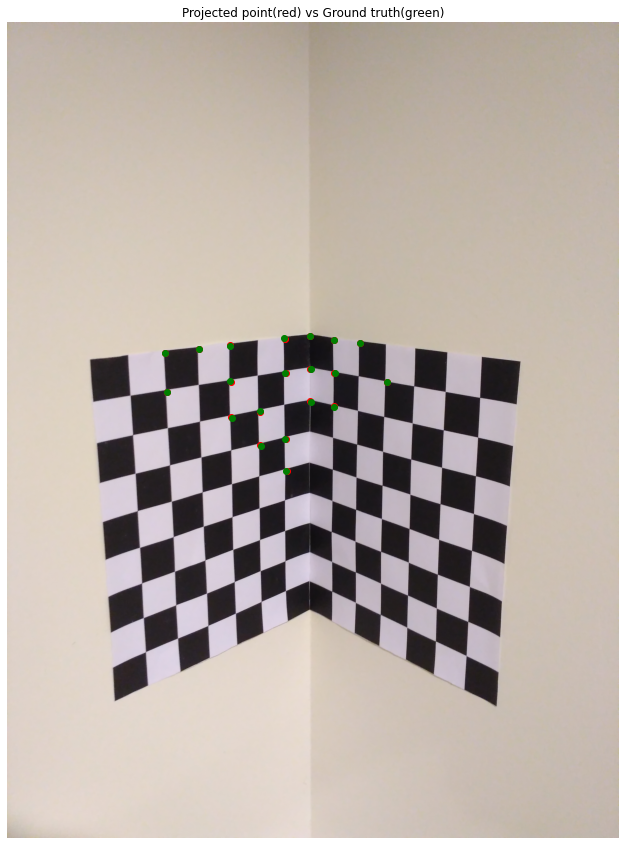

In [354]:
print("\n PART A \n")
print(x_hom.shape,X_hom.shape)
P_normal, error = get_calibration(x_hom,X_hom)
print("The final P matrix for scale 28x28mm is")
print(P_normal)
print("\nThe MSE between calculated and actual image points for scale 28x28mm is",error)

print("\n PART B \n")
P, error = get_calibration(x_hom,X_hom,normalise=True)
print("The final P matrix for scale 28x28mm is")
print(P)
print("The MSE between calculated and actual image points (normalised) for scale 28x28mm is",error)

print("\n PART C \n")
P, error = get_calibration(x_hom,X_hom,normalise=True,sub=True)
print("The final P matrix for scale 28x28mm is")
print(P)
print("The MSE between calculated and actual image points (denormalised) for scale 28x28mm is",error)
plt.figure(figsize=(15,15))
plt.imshow(cv2.cvtColor(cv2.imread("../calibration-data/calib-object.jpg"),cv2.COLOR_BGR2RGB))
x_proj_normal = P_normal@X_hom.T
x_proj_normal = x_proj_normal.T
for i in range(20):
    proj = x_proj_normal[i,:]
    proj = proj/proj[2]
    imgp = x_hom[i,:]
    plt.plot(proj[0],proj[1], 'ro')
    plt.plot(imgp[0],imgp[1],'go')
plt.axis('off')
plt.title("Projected point(red) vs Ground truth(green)")
plt.show()

### For 2800x2800 mm scale

In [355]:
x_100_hom,X_100_hom = hom_coords(x,X*100)
print("\n PART A \n")
P, error = get_calibration(x_100_hom,X_100_hom)
print("The final P matrix for scale 2800x2800mm is")
print(P)
print("The MSE between calculated and actual image points for scale 2800x2800mm is",error)

print("\n PART B \n")
P, error = get_calibration(x_100_hom,X_100_hom,normalise=True)
print("The final P matrix for scale 2800x2800mm is")
print(P)
print("The MSE between calculated and actual image points (normalised) for scale 2800x2800mm is",error)

print("\n PART C \n")
P, error = get_calibration(x_100_hom,X_100_hom,normalise=True,sub=True)
print("The final P matrix for scale 2800x2800mm is")
print(P)
print("The MSE between calculated and actual image points (denormalised) for scale 28x28mm is",error)


 PART A 

The final P matrix for scale 2800x2800mm is
[[ 2.82153228e-02  4.95638182e-03 -6.21523645e-02  1.54538814e+03]
 [-9.33101615e-03  6.51391364e-02 -1.36285365e-02  1.60071873e+03]
 [-9.56405884e-06  3.04265520e-06 -1.16486478e-05  1.00000000e+00]]
The MSE between calculated and actual image points for scale 2800x2800mm is 9.377086187604883

 PART B 

After normalising
The final P matrix for scale 2800x2800mm is
[[ 0.62415981  0.01140254 -0.69187038  0.05245988]
 [ 0.1242891   0.89488346  0.11751095  0.01217896]
 [-0.03294724  0.01097098 -0.04089333  1.        ]]
The MSE between calculated and actual image points (normalised) for scale 2800x2800mm is 0.00017063036085756614

 PART C 

After normalising
The final P matrix for scale 2800x2800mm is
[[ 3.01424203e-02  5.33468904e-03 -6.54142896e-02  1.62736786e+03]
 [-9.42061945e-03  6.87824236e-02 -1.42695954e-02  1.68551476e+03]
 [-9.84909743e-06  3.27961374e-06 -1.22244665e-05  1.05306567e+00]]
The MSE between calculated and actu

# Observations

### Scaling

1. We observe that the reprojection error hasn't changed much.
2. The last column of both the projection matrices (28mm and 2800mm) are the same.
3. The first three columns vary by a scale of 100. The Projection matrix for the 2800mm x 2800mm case has its scale reduced by a factor of 100. This is because, the X,Y and Z coordinates were scaled by a factor of 100.

### Normalisaton

1. We observe that the reprojection error has reduced significantly. This is because normalisation removed the effect of the coordinate frame we choose.

Normalization also helps in removing errors caused by-
- Different units for image and world points.
- Removed effect of coordinate frame by making the centroid of the points 0 and the average absoltute coordinate value 1.

# Q)1.2

In [378]:
def ret_RKT(P):
    """
    """
    H = np.array(P[:,0:3]).reshape(3,3)
    h = np.array(P[:,3]).reshape(3,1)
    H1 = np.linalg.inv(H)
    X0 = -np.dot(H1,h)
    
    #print(H1,h)
    R1, K1 = np.linalg.qr(H1)
    R = R1.T
    T = np.dot(R,-X0)
    K = np.linalg.inv(K1)
    K = K/K[-1,-1]
    return R, K , T, X0
P, error = get_calibration(x_hom,X_hom)
R,K,T,X0 = ret_RKT(P)
print("The rotation matrix is")
print(R)
print("The K matrix is")
print(K)
print("The translation matrix is")
print(T)
print("The Camera Center is")
print(X0)
T= T.reshape((3))
K= K.reshape((3,3))
P_recovered = np.empty((3,4))
P_recovered[:3,:3] = K@R
P_recovered[:,3] = K@T
P_recovered /= P_recovered[-1,-1]
print("The recovered P matrix is")
print(P_recovered)
print("The original P matrix is")
print(P)
print("As we can see, they are the same after multiplying the component matrices together")

def get_RK_positive(R,K,T):
    Rz = np.array([[-1,0,0],[0,-1,0],[0,0,1]])
    R1 = Rz@R
    T1 = Rz@T
    K1 = K@Rz
    return R1,K1,T1
R1, K1, T1 = get_RK_positive(R,K,T)
print("AFTER ALTERING THE MATRICES")
print("The rotation matrix is")
print(R1)
print("The K matrix is")
print(K1)
print("The translation matrix is")
print(T1)
P_recovered = np.empty((3,4))
P_recovered[:3,:3] = K1@R1
P_recovered[:,3] = K1@T1
P_recovered /= P_recovered[-1,-1]
print("The recovered P matrix after altering the diagonal elements is")
print(P_recovered)
print("As we can see the decomposition still holds as the reconstructed P matrix is the same")

The rotation matrix is
[[-0.72773258 -0.05174039  0.68390659]
 [ 0.54025359 -0.65754598  0.52512792]
 [ 0.42252971  0.75163569  0.50647056]]
The K matrix is
[[-1.12437126e+03 -2.44822658e+01  2.24456451e+02]
 [-0.00000000e+00 -1.10378487e+03  6.25280077e+02]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]
The translation matrix is
[[-0.19868776]
 [ 3.35542591]
 [23.3133149 ]]
The Camera Center is
[[-11.80794063]
 [-15.32705291]
 [-13.43365173]]
The recovered P matrix is
[[ 3.85983067e+01  1.04225035e+01 -2.86591872e+01  2.30515237e+02]
 [-1.42461222e+01  5.12913816e+01 -1.12786323e+01  4.66415137e+02]
 [ 1.81239653e-02  3.22406185e-02  2.17245195e-02  1.00000000e+00]]
The original P matrix is
[[ 3.85983067e+01  1.04225035e+01 -2.86591872e+01  2.30515237e+02]
 [-1.42461222e+01  5.12913816e+01 -1.12786323e+01  4.66415137e+02]
 [ 1.81239653e-02  3.22406185e-02  2.17245195e-02  1.00000000e+00]]
As we can see, they are the same after multiplying the component matrices together
AFTER ALT

# RANSAC ALGORITHM

In [357]:
def RANSAC(X_hom,x_hom,inlier_thresh,num_iter):
    corresponding_points = []
    for i in range(20):
        corresponding_points.append([X_hom[i,:],x_hom[i,:]])
    P_final = np.zeros((3,4))
    error_final = np.inf
    max_inliers = 0
    final_error = 0
    for i in range(num_iter):
        random_samples = random.sample(corresponding_points,6)   
        X_samples = []
        x_samples = []
        for i in random_samples:
            X_samples.append(i[0])
            x_samples.append(i[1])
        X_samples = np.array(X_samples)
        x_samples = np.array(x_samples)
        P, error = get_calibration(x_samples,X_samples)
        inliers = 0
        sum_error = 0
        for i in range(20):
            world_point = X_hom[i,:]
            img_proj = P@world_point
            img_proj = img_proj/img_proj[2]
            error = (img_proj[0] - x_hom[i,:][0]) ** 2 + (img_proj[1] - x_hom[i,:][1]) ** 2 
            sum_error+=error
            error = np.sqrt(error)
            if error < inlier_thresh:
                inliers+=1

        if inliers>=max_inliers and error<error_final:
            error_final = sum_error/20
            max_inliers = inliers
            P_final = P
    return error_final, max_inliers, P_final

In [359]:
error, inliers, P_best = RANSAC(X_hom,x_hom,10,100)
print("The error for the best P matrix is\n")
print(error)
print("The number of inliers are\n")
print(inliers)
print("The best P matrix is\n")
print(P_best)


The error for the best P matrix is

10.71229001146598
The number of inliers are

20
The best P matrix is

[[ 3.11484182e+00  4.84011004e-01 -6.20405277e+00  1.54502043e+03]
 [-6.76584009e-01  6.48443382e+00 -1.32696487e+00  1.60053021e+03]
 [-8.06632636e-04  2.94552733e-04 -1.14924337e-03  1.00000000e+00]]


<ipython-input-353-cfac1458fe77>:13: RuntimeWarning: divide by zero encountered in true_divide
  P = P/P[2,3]
<ipython-input-353-cfac1458fe77>:13: RuntimeWarning: invalid value encountered in true_divide
  P = P/P[2,3]
<ipython-input-353-cfac1458fe77>:18: RuntimeWarning: invalid value encountered in matmul
  points = P@X.T
<ipython-input-357-a9e97b95391e>:23: RuntimeWarning: invalid value encountered in matmul
  img_proj = P@world_point


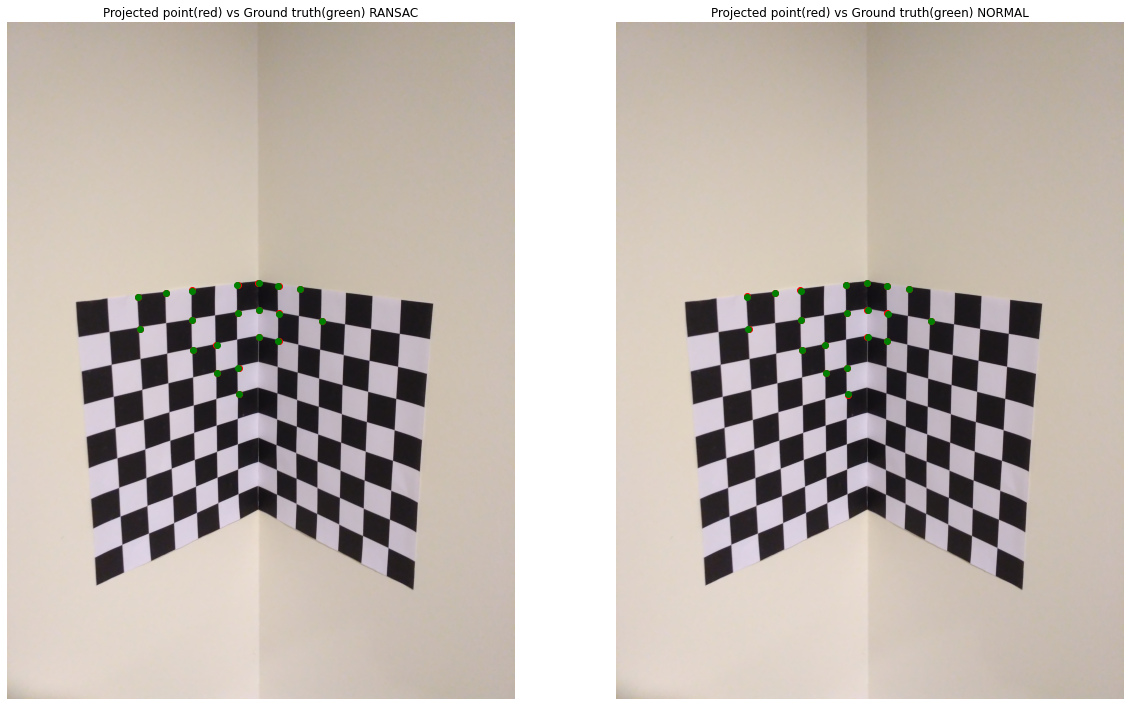

In [360]:
fig = plt.figure(figsize=(20,20))
ax = fig.add_subplot(1,2,1)
x_proj_normal = P_best@X_hom.T
x_proj_normal = x_proj_normal.T
ax.imshow(cv2.cvtColor(cv2.imread("../calibration-data/calib-object.jpg"),cv2.COLOR_BGR2RGB))
for i in range(20):
    proj = x_proj_normal[i,:]
    proj = proj/proj[2]
    imgp = x_hom[i,:]
    ax.plot(proj[0],proj[1], 'ro')
    ax.plot(imgp[0],imgp[1],'go')
ax.axis('off')
ax.title.set_text("Projected point(red) vs Ground truth(green) RANSAC")

P_normal, error = get_calibration(x_hom,X_hom)
ax = fig.add_subplot(1,2,2)
ax.imshow(cv2.cvtColor(cv2.imread("../calibration-data/calib-object.jpg"),cv2.COLOR_BGR2RGB))
x_proj_normal = P_normal@X_hom.T
x_proj_normal = x_proj_normal.T
for i in range(20):
    proj = x_proj_normal[i,:]
    proj = proj/proj[2]
    imgp = x_hom[i,:]
    ax.plot(proj[0],proj[1], 'ro')
    ax.plot(imgp[0],imgp[1],'go')
ax.axis('off')
ax.title.set_text("Projected point(red) vs Ground truth(green) NORMAL")

## 1.3.b

## Answer

- We are given that the probability of choosing an inlier is 80%, $w = 0.8$.
- We want a minimum success probability of $p = 0.95$.
- To note- In my RANSAC, $n=6$.

Derivation of Formula:

1. Probability of choosing all n points as inlier points = $ω^{n}$
2. Thus, choosing atleast one point which is not an inlier = $1-ω^{n}$
3. Going k iterations without getting all points as inlier points = $(1-ω^{n})^{k}$
4. Getting all n points as inliers in atleast 1 of the k iterations = $1 - (1-ω^{n})^{k}$

Hence, 

$$ p = 1-(1-ω^{n})^{k} $$

For my case, substituting $p = 0.95$, $n = 6$, $w = 0.8$, we get $k = 9.854168689635499$.
Thus, we need a minimum of $10$ iterations to get a probability of $0.95$.

## 1.3.c

No handles with labels found to put in legend.


In order to get minimum 95% success, we need to run it for

10
epochs


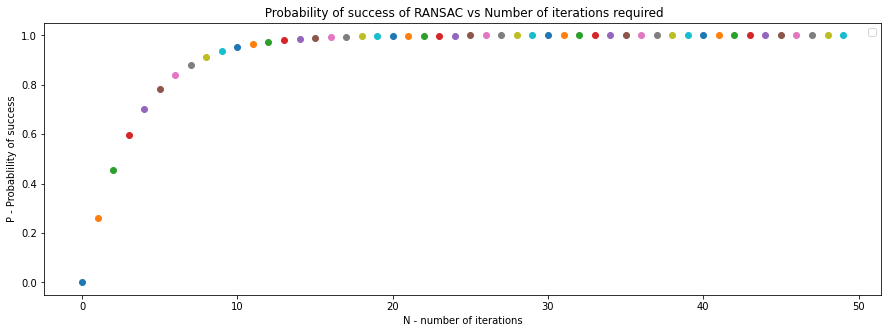

In [364]:
n=6 # I have 17 points in my RANSAC
def no_iter(k,w):
    var = 1 - (1-w**n)**k
    return var

fig = plt.figure(figsize=(15,5)) 
for i in range(0,50,1):
    plt.plot(i, no_iter(i,0.8),marker='o')

print("In order to get minimum 95% success, we need to run it for\n")
print( int(np.log(0.05)/np.log(1-(0.8)**6)) +1)
print ("epochs")
plt.title(' Probability of success of RANSAC vs Number of iterations required')
plt.xlabel('N - number of iterations')
plt.ylabel('P - Probablility of success')
plt.legend()
#plt.axis('off')
plt.show()    

## Bonus Question

(20, 2) (20, 3)
16.70080115680718
Distortion Parameters :  [[-2.06944403e+00  4.11825123e+01 -3.03299724e-02 -2.40219194e-02
  -2.69207488e+02]]


<ipython-input-353-cfac1458fe77>:13: RuntimeWarning: divide by zero encountered in true_divide
  P = P/P[2,3]
<ipython-input-353-cfac1458fe77>:13: RuntimeWarning: invalid value encountered in true_divide
  P = P/P[2,3]
<ipython-input-353-cfac1458fe77>:18: RuntimeWarning: invalid value encountered in matmul
  points = P@X.T
<ipython-input-357-a9e97b95391e>:23: RuntimeWarning: invalid value encountered in matmul
  img_proj = P@world_point


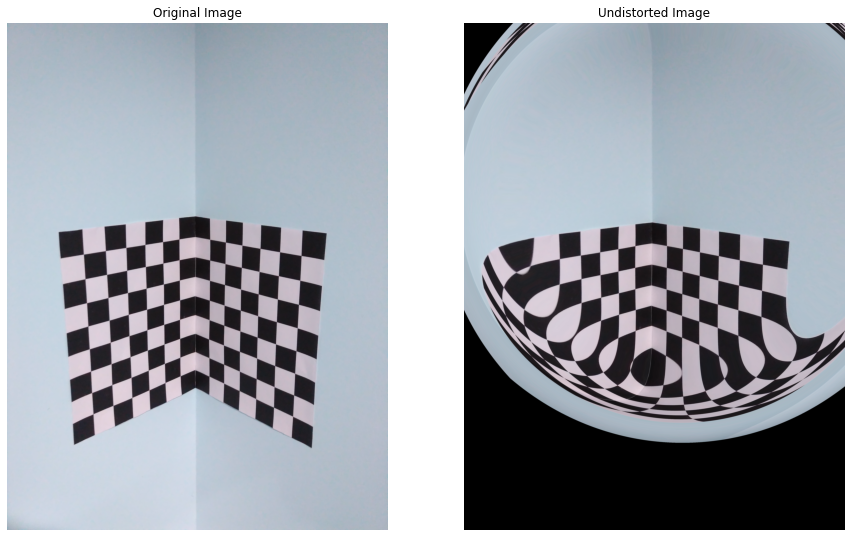

In [367]:
imgx = cv2.imread("../calibration-data/calib-object.jpg")
# cp = np.load('./dist_pixel_coordinates.npy')
# wp = np.load('./dist_world_coordinates.npy')
cp = x
wp = X
print(cp.shape,wp.shape)
cp_hom, wp_hom = hom_coords(cp,wp)
error, inliers, P_best = RANSAC(wp_hom,cp_hom,3,100)
R,k_temp,T,X0 = ret_RKT(P_best)
print(error)
k_temp[0,1] = 0

ret, oldK, dist, rvecs, tvecs = cv2.calibrateCamera(np.array([wp]).astype(np.float32), 
                                                   np.array([cp]).astype(np.float32),
                                                   (imgx.shape[1],imgx.shape[0]),
                                                   k_temp,None, None,flags=(cv2.CALIB_USE_INTRINSIC_GUESS ))
print("Distortion Parameters : ", dist)

ht,wt = imgx.shape[:2]

newK,_ = cv2.getOptimalNewCameraMatrix(k_temp,dist,(wt,ht),1,(wt,ht))

I_undistort = cv2.undistort(imgx,oldK,dist,None,newK)

plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.imshow(imgx)
plt.axis('off')
plt.title('Original Image')
plt.subplot(1,2,2)
plt.axis('off')
plt.imshow(I_undistort)
plt.title('Undistorted Image')
plt.show()

- The horrible results above may be due to the fact that I did not choose the image points accurately.

# Question 2- Zhang's Method
#### Reference I used for this code-
- https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_calib3d/py_calibration/py_calibration.html

In [368]:
x,y=np.meshgrid(range(8),range(6))
worldpoints = np.hstack((x.reshape(48,1),y.reshape(48,1),np.zeros((48,1)))).astype(np.float32)

In [369]:
# Arrays to store object points and image points from all the images.
objpoints = [] # 3d point in real world space
imgpoints = [] # 2d points in image plane.
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)

for i in range(5456,5471):
    im=cv2.imread('../calibration-data/IMG_' + str(i) + '.JPG')
    gray = cv2.cvtColor(im,cv2.COLOR_BGR2GRAY)
    ret, corners = cv2.findChessboardCorners(gray, (8,6),None)
    corners = np.squeeze(corners)
    if ret == True:
        imgpoints.append(corners)
        objpoints.append(worldpoints)

In [370]:
ret, k_mat, dist_coeff, rot_vec, trans_vec = cv2.calibrateCamera(objpoints,imgpoints, (im.shape[1],im.shape[0]), None, None)

In [371]:
print("THE K MATRIX IS")
print(k_mat)
print("THE ROTATION VECTOR IS")
print(rot_vec)
print("THE TRANSLATION VECTOR IS")
print(trans_vec)
print("THE DISTORTION COEFFICIENTS ARE")
print(dist_coeff)

THE K MATRIX IS
[[1.36634773e+04 0.00000000e+00 3.33653656e+03]
 [0.00000000e+00 1.36813826e+04 1.49660118e+03]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
THE ROTATION VECTOR IS
[array([[-0.01318085],
       [-0.05189257],
       [-0.00310183]]), array([[-0.00723369],
       [ 0.22652165],
       [ 0.03532859]]), array([[-0.00906861],
       [-0.41619662],
       [-0.03572076]]), array([[ 0.01633962],
       [-0.61839259],
       [-0.07755518]]), array([[0.00456626],
       [0.30778498],
       [0.06543949]]), array([[-0.32566614],
       [-0.22232074],
       [-0.01742858]]), array([[-0.19221712],
       [-0.38502427],
       [-0.00381479]]), array([[ 0.24427921],
       [-0.32262063],
       [ 0.02472159]]), array([[0.31114498],
       [0.0663294 ],
       [0.07053942]]), array([[ 0.34957373],
       [-0.56388415],
       [-0.06027059]]), array([[ 0.22457427],
       [-0.40589216],
       [-0.05699645]]), array([[-0.11332318],
       [-0.29806938],
       [ 0.00488492]]), array

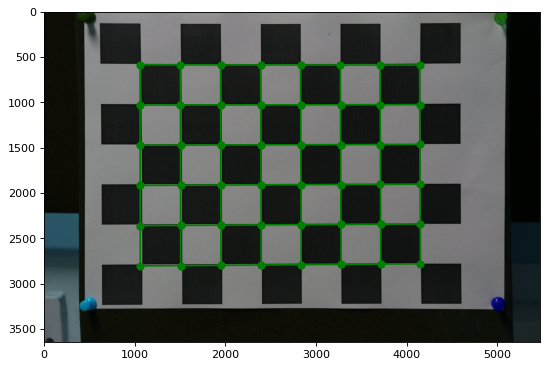

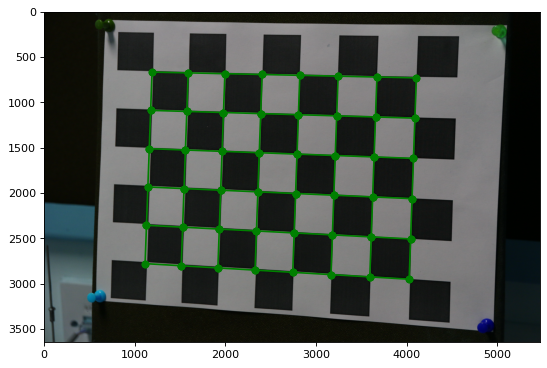

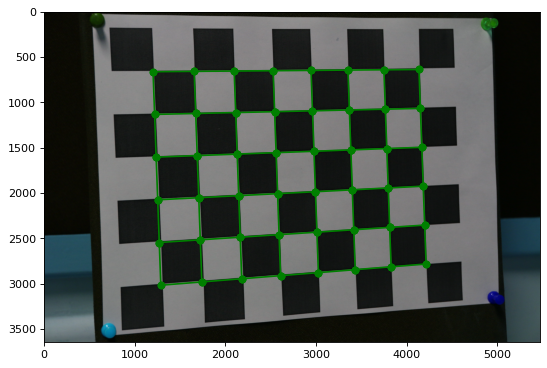

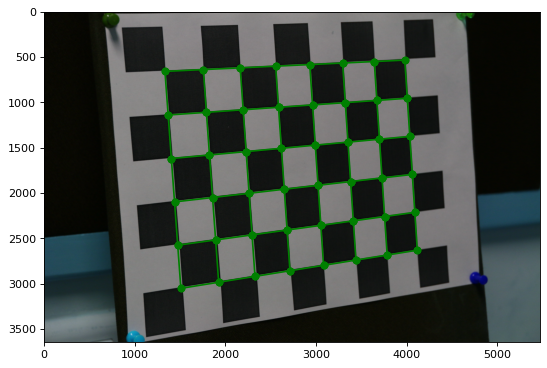

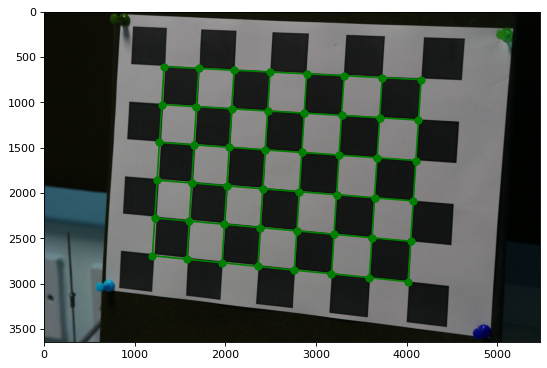

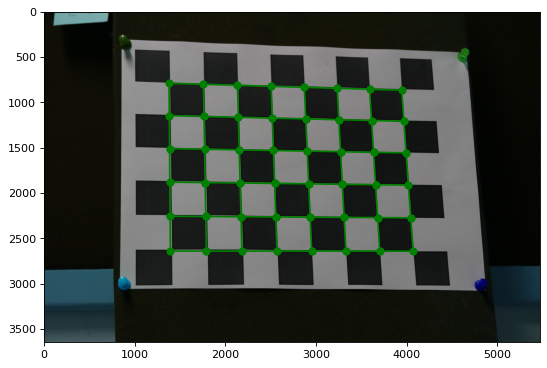

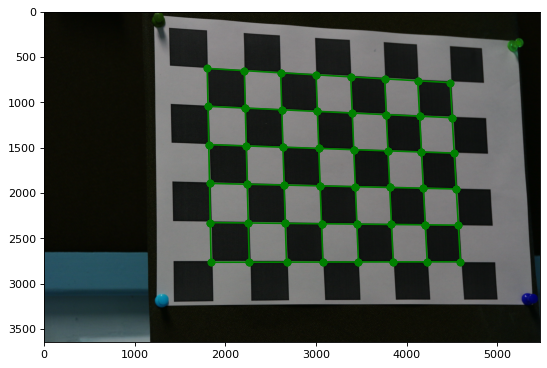

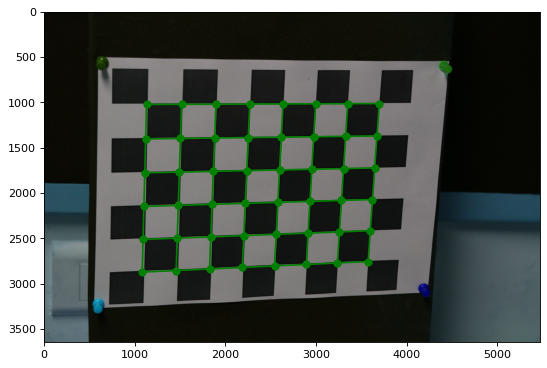

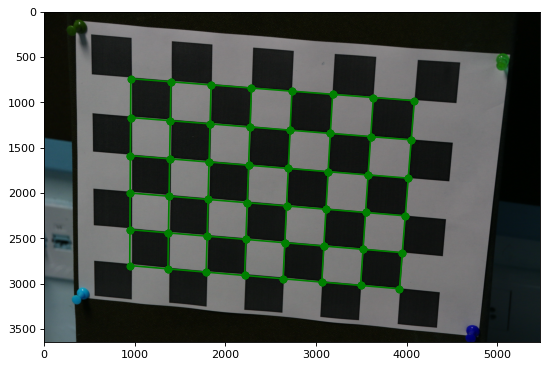

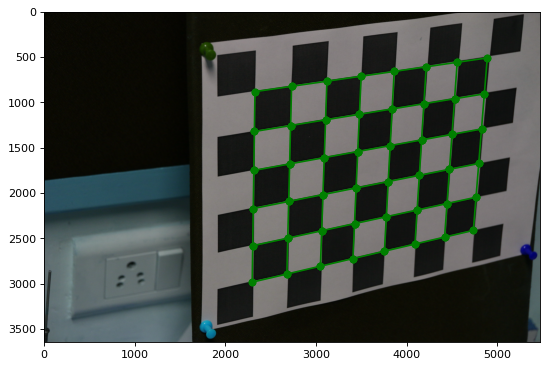

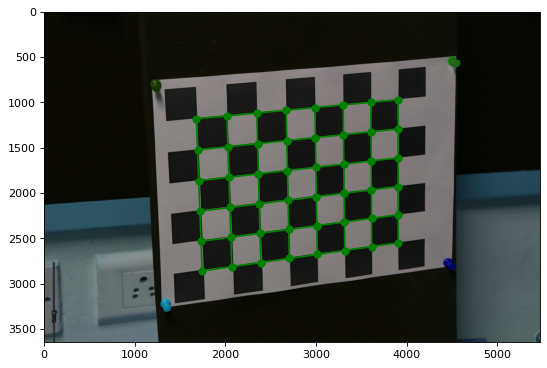

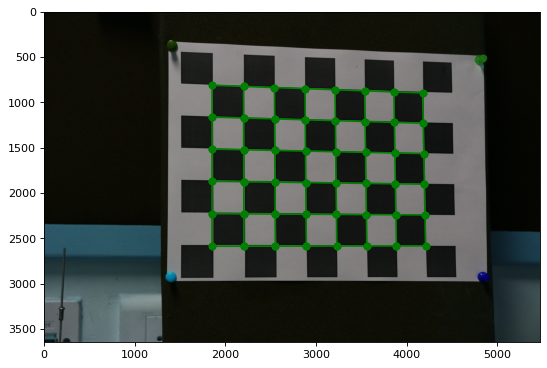

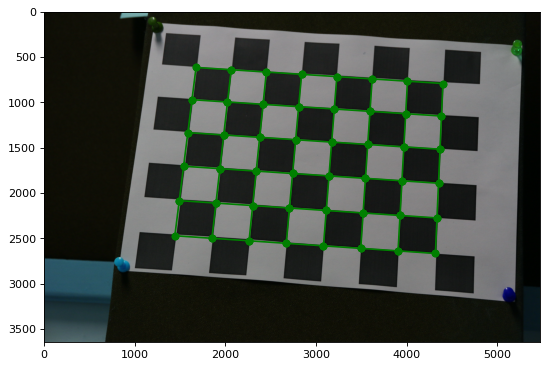

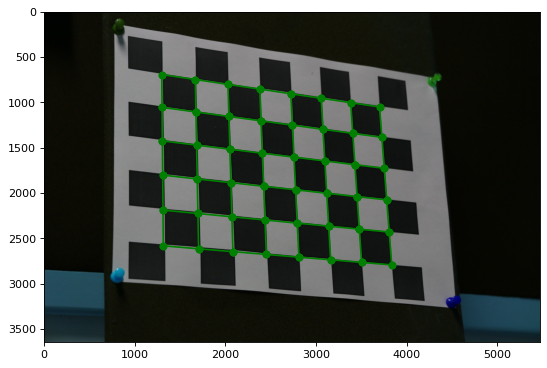

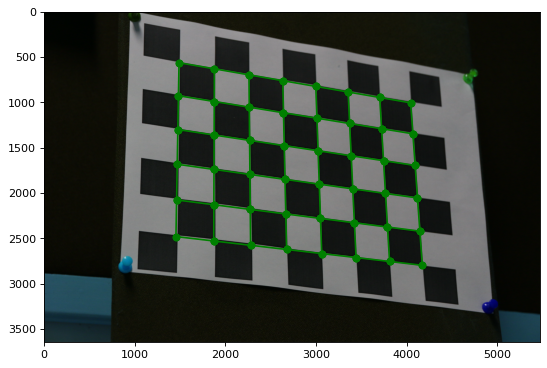

In [372]:
for i in range(15):
    im=cv2.imread('../calibration-data/IMG_' + str(5456 + i) + '.JPG')
    rot_mat = cv2.Rodrigues(rot_vec[i])[0]
    P = np.zeros((3,4))
    P[0:3,0:3] = rot_mat
    P[0:3,3] = trans_vec[i][:,0]
    P = k_mat @ P
    P = P/P[2,3]
    worldpoints_hom = np.hstack((worldpoints,np.ones((48,1))))
    img_proj = P@worldpoints_hom.T
    fig = plt.figure(figsize=(8,8),dpi=80)
    for j in range(1,48):
        normalisation_to = img_proj[:,j][2]
        normalisation_from = img_proj[:,j-1][2]
        if j%8==0:
            continue
        x_coord = [img_proj[:,j-1][0]/normalisation_from,img_proj[:,j][0]/normalisation_to]
        y_coord = [img_proj[:,j-1][1]/normalisation_from,img_proj[:,j][1]/normalisation_to]
        plt.plot(x_coord,y_coord,'go-')
    for j in range(8):
        for k in range(5):
            normalisation_from = img_proj[:,j + k*8][2]
            normalisation_to = img_proj[:,j + (k+1)*8][2]
            x_coord = [img_proj[:,j + k*8][0]/normalisation_from,img_proj[:,j + (k+1)*8][0]/normalisation_to]
            y_coord = [img_proj[:,j + k*8][1]/normalisation_from,img_proj[:,j + (k+1)*8][1]/normalisation_to]
            plt.plot(x_coord,y_coord,'go-')
    plt.imshow(im)
    plt.show()

# Observation

1. When the image is taken at a large, angle, the wireframe does not fit properly. This is 
especially visible in the last image. (Could be due to improper rotation and translation vectors).
2. However, for perpendicular lines, it fits perfectly.

## DLT on CUSTOM IMAGE

In [70]:
# Do not rerun this
%matplotlib tk
image_points = []
fig = plt.figure(figsize=(20,30))
img=mpimg.imread('../calibration-data/cube.jpeg')

def onclick(event):
    ix, iy = event.xdata, event.ydata
    # print(ix, iy)
    image_points.append([ix, iy])

cid = fig.canvas.mpl_connect('button_press_event', onclick)

imgplot = plt.imshow(img)
plt.show()
np.save("cube_points.npy",image_points)

In [373]:
image_points = np.load("cube_points.npy")

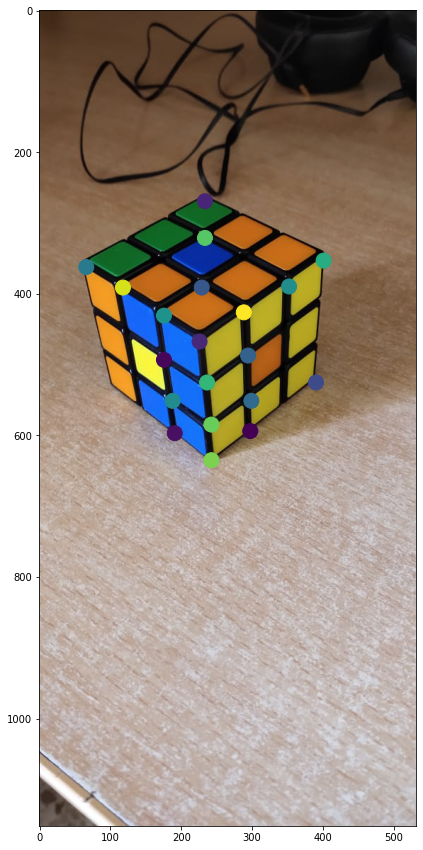

In [374]:
%matplotlib inline
N = 20
image_points = np.array(image_points)
fig = plt.figure(figsize=(10,15))

img=mpimg.imread('../calibration-data/cube.jpeg')
imgplot = plt.imshow(img)

colors = np.random.rand(N)
area = (15 * np.ones(N))**2 

plt.scatter(image_points[:,0], image_points[:,1], c=colors, s=area)
plt.show()

In [375]:
x = image_points
# X represents the 3D world points
X = []
X.append([0,0,0])
X.append([1.83,0,0])
X.append([3.66,0,0])
X.append([5.5,0,0])
X.append([0,1.83,0])
X.append([1.83,0,1.83])
X.append([3.66,0,3.66])
X.append([5.5,0,5.5])
X.append([0,0,1.83])
X.append([0,0,3.66])
X.append([0,0,5.5])
X.append([0,1.83,1.83])
X.append([0,3.66,1.83])
X.append([0,5.5,1.83])
X.append([0,3.66,0])
X.append([0,5.5,0])
X.append([1.83,1.83,0])
X.append([1.83,3.66,0])
X.append([1.83,5.5,0])
X.append([5.5,5.5,0])
X = np.array(X)

x_hom,X_hom = hom_coords(x,X)

# With DLT

In [376]:
print("\n PART A \n")
print(x_hom.shape,X_hom.shape)
P, error = get_calibration(x_hom,X_hom)
print("The final P matrix is")
print(P)
print("\nThe MSE between calculated and actual image points is",error)

print("\n PART B \n")
P, error = get_calibration(x_hom,X_hom,normalise=True)
print("The final P matrix for normalised points is")
print(P)
print("The MSE between calculated and actual image points for normalised points is",error)

print("\n PART C \n")
P, error = get_calibration(x_hom,X_hom,normalise=True,sub=True)
print("The final P matrix for denormalised points is")
print(P)
print("The MSE between calculated and actual image points for denormalised points is",error)


 PART A 

(20, 3) (20, 4)
The final P matrix is
[[ 3.85983067e+01  1.04225035e+01 -2.86591872e+01  2.30515237e+02]
 [-1.42461222e+01  5.12913816e+01 -1.12786323e+01  4.66415137e+02]
 [ 1.81239653e-02  3.22406185e-02  2.17245195e-02  1.00000000e+00]]

The MSE between calculated and actual image points is 12.55993619933168

 PART B 

After normalising
The final P matrix for normalised points is
[[ 0.68709325  0.05214228 -0.68218714  0.01184475]
 [-0.45663     0.72848201 -0.43166648  0.02142517]
 [ 0.0317045   0.05613484  0.03854107  1.        ]]
The MSE between calculated and actual image points for normalised points is 0.0017916014517503354

 PART C 

After normalising
The final P matrix for denormalised points is
[[ 3.46155760e+01  9.57880662e+00 -2.53087312e+01  2.04272242e+02]
 [-1.24241545e+01  4.62583151e+01 -9.62184207e+00  4.13715342e+02]
 [ 1.68117773e-02  2.97663226e-02  2.04369715e-02  8.86960083e-01]]
The MSE between calculated and actual image points for denormalised points

## With RANSAC

<ipython-input-353-cfac1458fe77>:13: RuntimeWarning: divide by zero encountered in true_divide
  P = P/P[2,3]
<ipython-input-353-cfac1458fe77>:13: RuntimeWarning: invalid value encountered in true_divide
  P = P/P[2,3]
<ipython-input-353-cfac1458fe77>:18: RuntimeWarning: invalid value encountered in matmul
  points = P@X.T
<ipython-input-357-a9e97b95391e>:23: RuntimeWarning: invalid value encountered in matmul
  img_proj = P@world_point


The error for the best P matrix is

25.108352821291067
The number of inliers are

20
The best P matrix is

[[ 3.75920672e+01  1.20986332e+01 -2.80373962e+01  2.28418896e+02]
 [-1.68640916e+01  5.31003915e+01 -8.90705553e+00  4.66084314e+02]
 [ 1.08544507e-02  3.70853956e-02  2.70487353e-02  1.00000000e+00]]


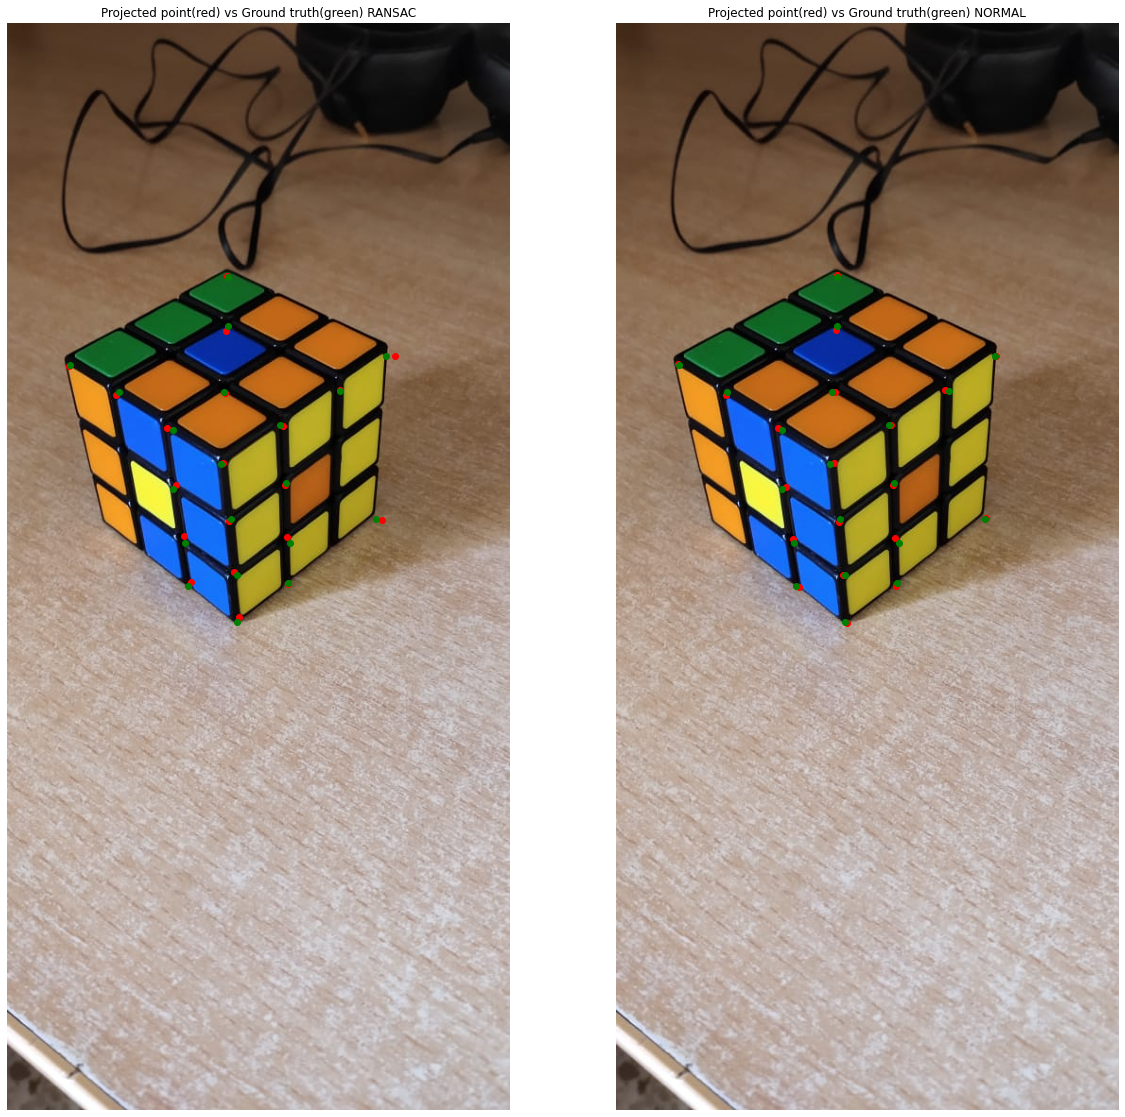

In [377]:
error, inliers, P_best = RANSAC(X_hom,x_hom,10,1000)
print("The error for the best P matrix is\n")
print(error)
print("The number of inliers are\n")
print(inliers)
print("The best P matrix is\n")
print(P_best)
fig = plt.figure(figsize=(20,20))
ax = fig.add_subplot(1,2,1)
x_proj_normal = P_best@X_hom.T
x_proj_normal = x_proj_normal.T
ax.imshow(cv2.cvtColor(cv2.imread("../calibration-data/cube.jpeg"),cv2.COLOR_BGR2RGB))
for i in range(20):
    proj = x_proj_normal[i,:]
    proj = proj/proj[2]
    imgp = x_hom[i,:]
    ax.plot(proj[0],proj[1], 'ro')
    ax.plot(imgp[0],imgp[1],'go')
ax.axis('off')
ax.title.set_text("Projected point(red) vs Ground truth(green) RANSAC")

P_normal, error = get_calibration(x_hom,X_hom)
ax = fig.add_subplot(1,2,2)
ax.imshow(cv2.cvtColor(cv2.imread("../calibration-data/cube.jpeg"),cv2.COLOR_BGR2RGB))
x_proj_normal = P_normal@X_hom.T
x_proj_normal = x_proj_normal.T
for i in range(20):
    proj = x_proj_normal[i,:]
    proj = proj/proj[2]
    imgp = x_hom[i,:]
    ax.plot(proj[0],proj[1], 'ro')
    ax.plot(imgp[0],imgp[1],'go')
ax.axis('off')
ax.title.set_text("Projected point(red) vs Ground truth(green) NORMAL")